In [2]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch

def load_datasets(directory):
    image_paths, labels = [], []
    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, label)):
            image_paths.append(os.path.join(directory, label, filename))
            labels.append(label)
    return image_paths, labels

train_dir = "../data/train"
test_dir = "../data/test"

train_paths, train_labels = load_datasets(train_dir)
test_paths, test_labels = load_datasets(test_dir)

le = LabelEncoder()
y_train = torch.tensor(le.fit_transform(train_labels), dtype=torch.long)
y_test = torch.tensor(le.transform(test_labels), dtype=torch.long)
label_names = le.classes_


In [3]:
from transformers import AutoImageProcessor
from PIL import Image

model_name = "trpakov/vit-face-expression"
processor = AutoImageProcessor.from_pretrained(model_name)

def extract_vit_inputs(image_paths):
    images = [Image.open(p).convert("RGB") for p in image_paths]
    inputs = processor(images=images, return_tensors="pt")
    return inputs["pixel_values"]

x_train = extract_vit_inputs(train_paths)
x_test = extract_vit_inputs(test_paths)


In [4]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [5]:
from transformers import AutoModelForImageClassification, AdamW
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForImageClassification.from_pretrained(model_name)
for param in model.vit.parameters():
    param.requires_grad = False  # freeze the last mlp part
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()


/Users/mo/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
from tqdm import tqdm
import copy

best_val_acc = 0.0
patience = 3
patience_counter = 0
best_model_path = "finetuned_vit.pt"

for epoch in range(20):
    model.train()
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Train Acc: {train_acc:.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f"Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("save model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early Stopping")
            break


Epoch 1: 100%|██████████| 1795/1795 [23:22<00:00,  1.28it/s]


Train Acc: 0.9895
Val Acc: 0.7093
新的最佳模型已保存！


Epoch 2: 100%|██████████| 1795/1795 [21:44<00:00,  1.38it/s]


Train Acc: 0.9895
Val Acc: 0.7083


Epoch 3: 100%|██████████| 1795/1795 [22:22<00:00,  1.34it/s]


Train Acc: 0.9896
Val Acc: 0.7086


Epoch 4: 100%|██████████| 1795/1795 [26:38<00:00,  1.12it/s]


Train Acc: 0.9896
Val Acc: 0.7079
触发 Early Stopping


/var/folders/wp/l8c79r0x3rd_31sm3pkk2ccc0000gn/T/ipykernel_49731/3865150790.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("finetuned_

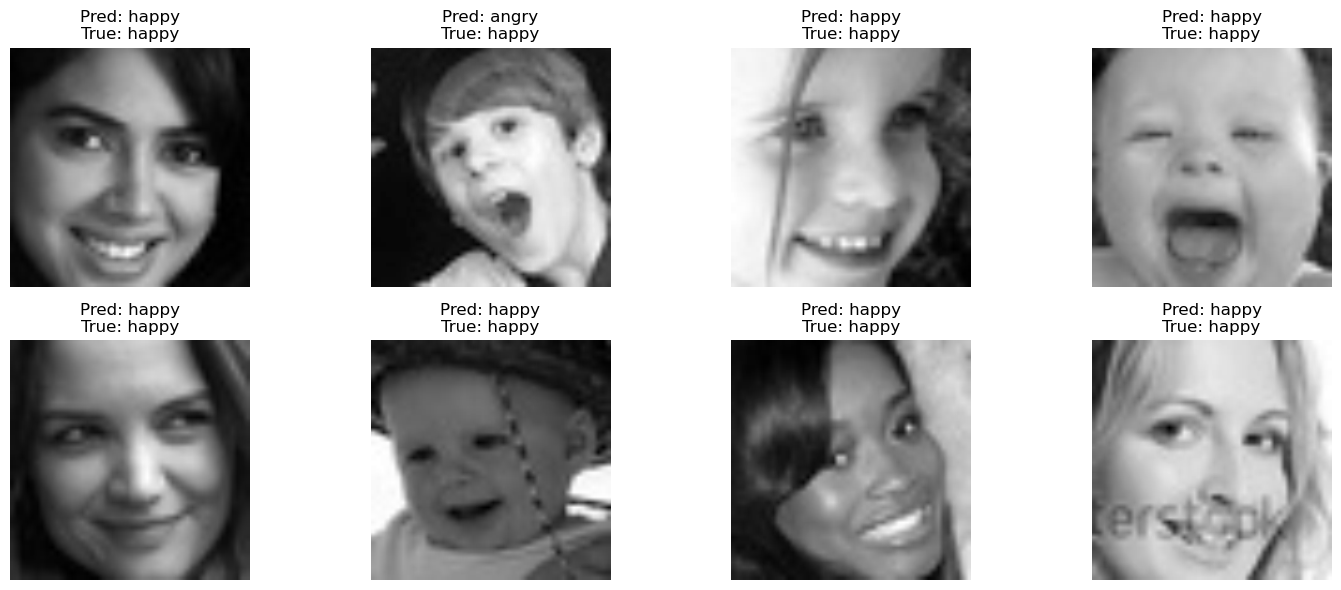

In [8]:
import matplotlib.pyplot as plt

def visualize_predictions(x_tensor, y_tensor, label_names, model, num_images=8):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor[:num_images].to(device)
        y_tensor = y_tensor[:num_images].to(device)
        outputs = model(pixel_values=x_tensor).logits
        preds = outputs.argmax(dim=1).cpu().numpy()

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        img = x_tensor[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # 归一化
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {label_names[preds[i]]}\nTrue: {label_names[y_tensor[i].item()]}")
    plt.tight_layout()
    plt.show()

model.load_state_dict(torch.load("finetuned_vit.pt"))

#  visualize the first 8 pictures
visualize_predictions(x_test, y_test, label_names, model, num_images=8)



In [ ]:
#